# Load and display data

The format of the input is simply a $(N, D)$ numpy array containing $N$ data points $x_i \in \mathbb{R}^D$.
In the data folder can be found a set of 2666 datapoints from a toy dataset generated as a superimposition of three noisy branches with several standard deviations, one Gaussian cluster at the center and 25% uniform background noise. Let's have a look at it!

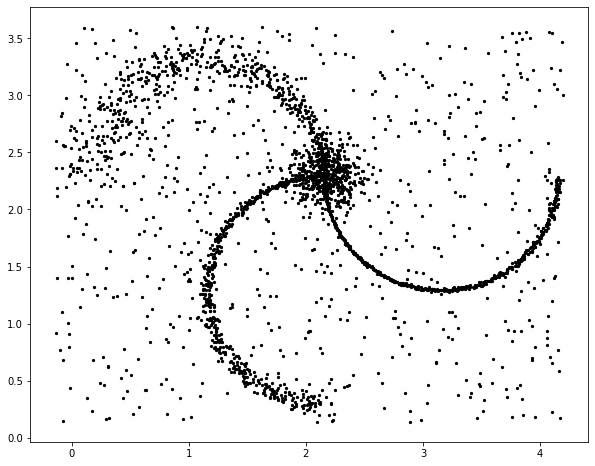

In [3]:
import numpy as np

#Add sources to path
import sys
sys.path.insert(1, '../src/')

import networkAlgo as na          #Graph management
import regularization_gmm as rg   #RegGMM algorithm
import matplotlib.pyplot as plt
import utility as utility         #For plots and internal functions

# Plots parameters
axSize = [0.1,0.1,0.8,0.8]
cbarPos = [0.9, 0.1, 0.025, 0.8]
figSize = (10, 8)

#Loading data
data = np.load('../data/toy_dataset.npy')

#Plot
fig, ax = plt.subplots(figsize=figSize)
ax.scatter(data.T[0], data.T[1], s=5, color='k')

# Run T-ReX to obtain a regularised graph

T-ReX can be run in few code lines to build a regularised graph. First, we need to set up a param object containing all the parameters of the computation. In this example, we make use of the minimum spanning tree topology with spherical and fixed covariance. Within a second, we get a set of optimal nodes position and edges.

In [4]:
# Set parameters of the T-ReX algorithm
param = rg.param_()
param.set(data=data, topology=na.buildMST_fast, verbose=0, covariance_type='spherical',
          covariance_update='adaptative', lam=5, lam_sig=5, lam_pi=1, maxIter=100, eps=1e-5)

# Set parameters for the background
param.background_noise = True
if param.background_noise:
    param.alpha = 0.1  # Initilisation of the noise level (true is 0.25)
else:
    param.alpha = 0
param.domain_area = np.prod(np.max(data, axis=0) - np.min(data, axis=0))  # Estimate of the volume containing the data

param.sig = 0.01  #Initialisation of the variance of Gaussian components

X = data      # Datapoints used for the computation

# Initialise the graph with 100 random datapoints
np.random.seed(10)
M = X[np.random.choice(np.arange(len(X)), 100, replace=False)]

#Get the regularised graph
regGraph, _, _, _ = rg.regGMM(X, M, param, computeObj=0, display_progress_bar=1)
opt_edges = regGraph.edges
F = regGraph.F

#Compute XYZ positions of edges for plots
Xe_fil, Ye_fil, Ze_fil = na.compute_XYZ_of_edges(opt_edges, F)

100%|██████████| 100/100 [00:01<00:00, 91.20it/s]

Time in E-step: 0.385
Time in M-step: 0.291


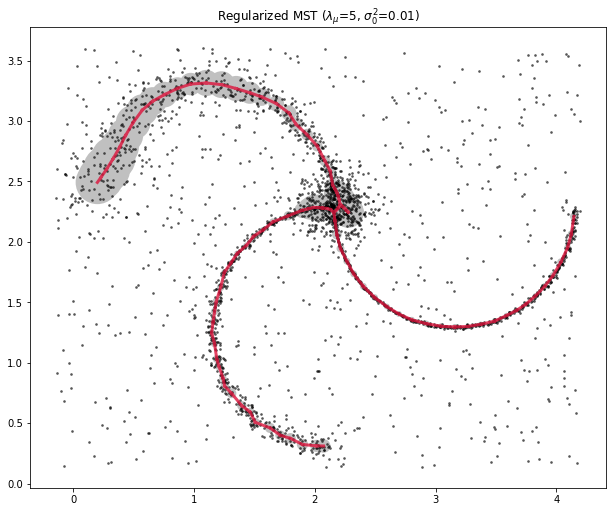

In [5]:
#Plot the regularised graph
fig, ax = utility.getFigure(figSize, axSize)
plt.scatter(data.T[0], data.T[1], color = 'k', s=3, alpha=0.5)

plt.plot(Xe_fil, Ye_fil, lineWidth=3, c='crimson', alpha=0.8, zorder=1)
plt.title('Regularized MST ($\lambda_\mu$={}, $\sigma_0^2$={:.2f})' .format(param.lam, param.sig))

#Plot covariance ellipses
for j in range(len(F)):
    if isinstance(regGraph.sig, np.ndarray):
        if param.covariance_update == 'adaptative':
            covMat = np.eye(2)*regGraph.sig[j]
        else:
            covMat = np.eye(2)*regGraph.sig[j]
    else:
        covMat = np.eye(2)*regGraph.sig
    ell = utility.get_cov_ellipse(covMat, F[j][0:2], 0.395, alpha=1, zorder=-1)   #0.395 to see 1-sigma circles
    ell.set_facecolor('silver')
    ax.add_artist(ell)
plt.show()

Let us check the noise level finally learnt.

In [6]:
print(regGraph.alpha)

0.24879102633612293


It corresponds to the level of noise we input.

# T-ReX as a 1D manifold denoiser

Since T-ReX is a probabilistic model, we can compute the probability, for each point, to be generated by one of the component or the background.

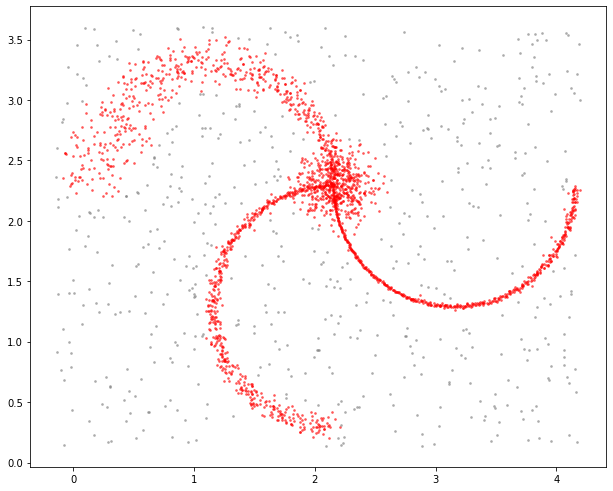

In [14]:
R,R_bn = regGraph.responsibilities   # Get the responsibilities computed during the learning

# Color the datapoints by zi==0 if the probability of being generated 
# by all the Gaussian is higher than the background noise
zi = np.zeros(len(data))
zi[R_bn > np.array(R.sum(axis=1)).T[0]] = -1

fig, ax = utility.getFigure(figSize, axSize)
plt.scatter(data[zi==0].T[0], data[zi==0].T[1], color='r', s=3, alpha=0.5)
plt.scatter(data[zi==-1].T[0], data[zi==-1].T[1], color='grey', s=3, alpha=0.5)

The T-ReX algorithm can hence also be used to denoise non-linear datasets with a 1D underlying structure, heteroscedastic sampling and robust to background noise!